# Modelo MS-MS para los cúmulos escogidos

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scienceplots

Consideremos la ecuación para la magnitud de un sistema binario (considerandolo como una fuente puntual) de Milone et al. 2018:

$$\mathrm{m_{bin}} = m_1 - 2.5 \log_{10}\left( 1 + \dfrac{F_2}{F_1}\right)$$

$$\mathrm{m_{bin}} = m_1 - 2.5 \log_{10}\left( 1 + \dfrac{L_2}{L_1}\right)$$

$$\mathrm{m_{bin}} = m_1 - 2.5 \log_{10}\left( 1 + \left[ \dfrac{M_2}{M_1} \right]^{3.5}\right)$$
$$\mathrm{m_{bin}} = m_1 - 2.5 \log_{10}\left( 1 + q^{3.5}\right)$$

In [2]:
def m_bin(m1, q):
    return m1 - 2.5 * np.log10(1 + q**(3.5))

In [14]:
df_ngc2808 = pd.read_csv('data/ngc2808.csv').dropna(subset=['phot_g_mean_mag', 'phot_bp_mean_mag', 'phot_rp_mean_mag'])
df_ngc4755 = pd.read_csv('data/ngc4755.csv').dropna(subset=['phot_g_mean_mag', 'phot_bp_mean_mag', 'phot_rp_mean_mag'])
df_ngc6694 = pd.read_csv('data/ngc6694.csv').dropna(subset=['phot_g_mean_mag', 'phot_bp_mean_mag', 'phot_rp_mean_mag'])

df_ngc2808 = df_ngc2808.rename(columns={'phot_g_mean_mag': 'g', 'phot_bp_mean_mag': 'bp', 'phot_rp_mean_mag': 'rp'})
df_ngc4755 = df_ngc4755.rename(columns={'phot_g_mean_mag': 'g', 'phot_bp_mean_mag': 'bp', 'phot_rp_mean_mag': 'rp'})
df_ngc6694 = df_ngc6694.rename(columns={'phot_g_mean_mag': 'g', 'phot_bp_mean_mag': 'bp', 'phot_rp_mean_mag': 'rp'})

df_ngc2808

,source_id,ra,dec,parallax,pmra,pmdec,ruwe,g,bp,rp,...,has_epoch_rv,has_mcmc_gspphot,has_mcmc_msc,teff_gspphot,logg_gspphot,mh_gspphot,distance_gspphot,azero_gspphot,ag_gspphot,ebpminrp_gspphot
3,5248755528149120000,138.024296,-64.929135,0.070233,0.945825,0.371544,1.073403,18.299477,18.758608,17.574652,...,False,True,False,4796.1020,4.8934,-2.1899,1394.6476,0.0484,0.0382,0.0208
5,5248755532441537920,138.011478,-64.928911,-0.227482,0.856067,0.516022,0.911725,19.463888,19.545732,18.564917,...,False,False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,5248755532441556480,138.012653,-64.927123,0.046681,1.181902,0.238126,1.049162,18.189415,18.469221,17.374987,...,False,True,True,5560.9487,4.7307,-3.9982,1912.3499,0.7492,0.6110,0.3392
7,5248755532441572480,138.016231,-64.929577,0.274601,0.331386,1.090192,1.260872,19.316927,19.471746,18.530224,...,False,False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,5248755532441596160,138.018486,-64.929335,-0.212133,0.341646,0.492101,0.981523,19.746737,20.237011,19.366340,...,False,False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21578,5248766149613510912,138.047601,-64.802394,0.060736,0.893860,1.670627,1.774715,18.851461,18.490362,17.469868,...,False,False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN
21579,5248766149613516032,138.049931,-64.801332,0.215902,0.950468,0.096581,0.956090,17.445337,18.019041,16.770721,...,False,True,True,5249.2046,4.6777,-0.9837,1354.6202,0.7180,0.5753,0.3129
21580,5248766149613518208,138.053069,-64.801380,0.386951,0.160657,0.838170,1.040802,19.775116,19.923334,18.780573,...,False,False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN
21581,5248766149613963264,138.043510,-64.801984,0.444670,0.575617,0.023597,0.969397,19.888430,20.703348,19.692366,...,False,False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [16]:
df_ngc2808['g_bin'], df_ngc4755['g_bin'], df_ngc6694['g_bin'] = m_bin(df_ngc2808['g'], 0.5), m_bin(df_ngc4755['g'], 0.5), m_bin(df_ngc6694['g'], 0.5)
df_ngc2808['bp_bin'], df_ngc4755['bp_bin'], df_ngc6694['bp_bin'] = m_bin(df_ngc2808['bp'], 0.5), m_bin(df_ngc4755['bp'], 0.5), m_bin(df_ngc6694['bp'], 0.5)
df_ngc2808['rp_bin'], df_ngc4755['rp_bin'], df_ngc6694['rp_bin'] = m_bin(df_ngc2808['rp'], 0.5), m_bin(df_ngc4755['rp'], 0.5), m_bin(df_ngc6694['rp'], 0.5)

df_ngc4755



,source_id,ra,dec,parallax,pmra,pmdec,ruwe,g,bp,rp,...,teff_gspphot,logg_gspphot,mh_gspphot,distance_gspphot,azero_gspphot,ag_gspphot,ebpminrp_gspphot,g_bin,bp_bin,rp_bin
0,6055652344041076352,193.510441,-60.458254,-0.007594,-8.155732,-1.829909,1.370937,20.321098,20.855968,19.114860,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20.229138,20.764008,19.022900
1,6055652584547243904,193.468282,-60.453078,0.584574,-10.213827,-1.783573,0.962558,19.208470,20.232410,18.268274,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,19.116510,20.140450,18.176314
2,6055652477159279872,193.433255,-60.469411,0.401651,-7.097710,-1.032569,1.016148,17.770750,18.448774,16.991890,...,4939.0730,4.7871,-1.4836,1046.6744,0.9739,0.7560,0.4110,17.678790,18.356814,16.899930
3,6055652477163000832,193.435895,-60.463539,0.369544,-10.964206,0.871068,0.966357,17.360992,17.988928,16.613853,...,4687.1147,4.3800,-1.2966,1539.9637,0.5575,0.4329,0.2351,17.269032,17.896968,16.521893
4,6055652477163000960,193.437947,-60.463675,0.454736,-5.686552,-1.001983,1.169018,17.967741,18.612896,17.073048,...,5280.6426,4.6946,-3.9461,1231.4875,1.4521,1.1352,0.6320,17.875781,18.520936,16.981088
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13587,6056784119473282944,193.434669,-60.273891,0.231488,-8.292362,-0.107035,0.995060,18.033321,19.240692,16.944681,...,4593.9840,4.4896,-0.6253,871.7272,2.6991,1.9359,1.0554,17.941361,19.148732,16.852721
13588,6056784119473593856,193.437733,-60.277995,0.280377,-5.842338,0.648103,0.927769,17.092838,17.803577,16.264463,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,17.000878,17.711617,16.172503
13589,6056784119486858624,193.431654,-60.278818,0.545498,-7.693063,-1.227550,1.011728,19.453352,19.994776,18.261452,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,19.361392,19.902816,18.169492
13590,6056784119487574528,193.447846,-60.272677,0.289127,-9.102897,-1.371390,1.095476,20.264935,21.266235,19.210377,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20.172975,21.174275,19.118417


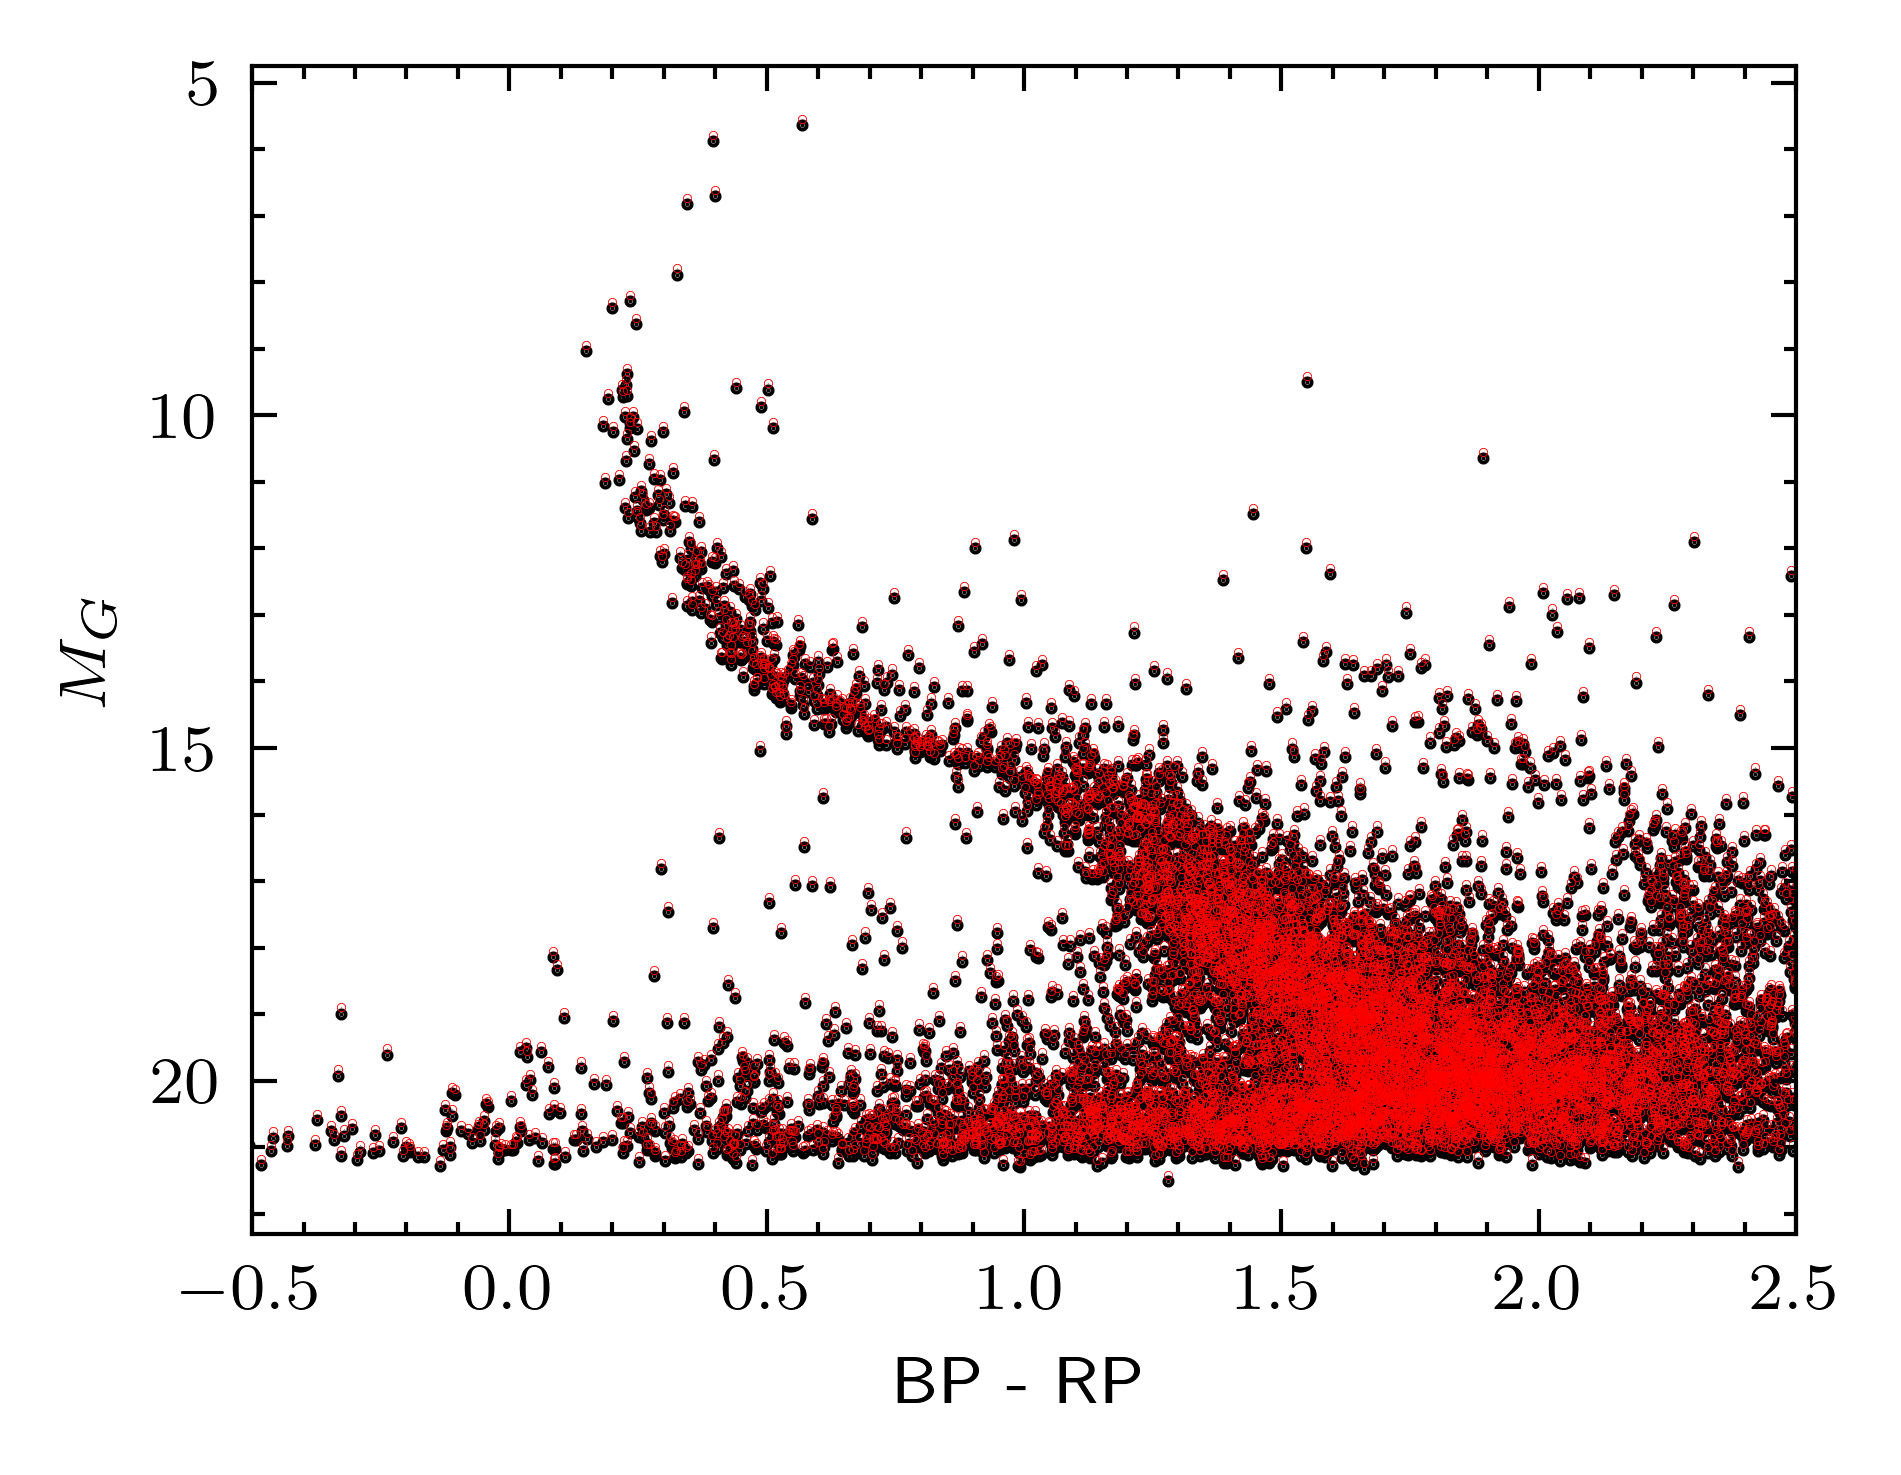

In [19]:
with plt.style.context(['science', 'ieee']):
    fig, ax = plt.subplots()
    ax.scatter(df_ngc4755['bp'] - df_ngc4755['rp'], df_ngc4755['g'], s=0.2)
    ax.scatter(df_ngc4755['bp_bin'] - df_ngc4755['rp_bin'], df_ngc4755['g_bin'], s=0.01)
    ax.set_xlabel('BP - RP')
    ax.set_ylabel('$M_{G}$')
    ax.set_xlim(-0.5, 2.5)
    ax.invert_yaxis()
    #fig.savefig('figures/HR_diagram_NGC2808.jpg', dpi=600)
    #plt.close()
    fig.tight_layout()